In [1]:
import pandas as pd
import numpy as np
import glob, os, sys
osp = sys.platform

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, TimeDistributed, BatchNormalization
from keras.layers import LSTM, GRU
from keras.optimizers import RMSprop, Adagrad, Adam, SGD
#from keras.models import load_model
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline

from utilities import LoadData
from helpers import id_player, id_position, get_player_trajectory, segment

# ---------------------------------------------------------
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
gameid='0021500463'

# directories
# CHANGE HERE
main_dir = '../'
game_dir = main_dir+'data/'
# court_path = data_dir + 'nba_court_T.png'

Data = LoadData(main_dir, game_dir)
data = Data.load_game(gameid)
event_number, moment_number = 0, 0

In [3]:
# get events and number of events
event_df = pd.DataFrame(data['events'])
n_events = event_df.shape[0]
# get numebr of moments
moments = event_df.iloc[event_number,:]['moments']
n_moments = len(moments)

print(n_moments, event_df.shape)
event_df.head()

150 (231, 8)


,end_time_left,home,moments,orig_events,playbyplay,quarter,start_time_left,visitor
0,702.31,"{'abbreviation': 'CHI', 'players': [{'playerid...","[[1, 1451351428029, 708.28, 12.78, None, [[-1,...",[0],GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,708.28,"{'abbreviation': 'TOR', 'players': [{'playerid..."
1,686.28,"{'abbreviation': 'CHI', 'players': [{'playerid...","[[1, 1451351428029, 708.28, 12.78, None, [[-1,...",[1],GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,708.28,"{'abbreviation': 'TOR', 'players': [{'playerid..."
2,668.42,"{'abbreviation': 'CHI', 'players': [{'playerid...","[[1, 1451351444029, 692.25, 12.21, None, [[-1,...","[2, 3]",GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,692.25,"{'abbreviation': 'TOR', 'players': [{'playerid..."
3,665.71,"{'abbreviation': 'CHI', 'players': [{'playerid...","[[1, 1451351463029, 673.22, 21.44, None, [[-1,...","[4, 5]",GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,673.22,"{'abbreviation': 'TOR', 'players': [{'playerid..."
4,646.64,"{'abbreviation': 'CHI', 'players': [{'playerid...","[[1, 1451351473027, 668.0, 22.9, None, [[-1, -...",[6],GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,668.00,"{'abbreviation': 'TOR', 'players': [{'playerid..."


In [4]:
# first try to predict next trajectories for single player
pid = 2200
pid_track = pd.DataFrame(event_df['moments'].apply(lambda m: get_player_trajectory(m, pid)))
pid_track = pid_track[pid_track.moments.apply(lambda m: len(m) != 0)]
pid_track.reset_index(inplace=True, drop=True)
pid_track['length'] = pid_track.moments.apply(lambda m: len(m))

In [5]:
pid_track.head()

,moments,length
0,"[[11.15334, 21.35529, 18.38063, 14.07976, 8.56...",150
1,"[[11.15334, 21.35529, 18.38063, 14.07976, 8.56...",550
2,"[[80.35941, 16.31437, 63.70549, 29.93382, 3.52...",596
3,"[[16.77111, 29.51087, 31.06114, 31.5842, 3.586...",289
4,"[[52.14782, 24.2909, 49.76765, 17.82403, 4.968...",610


In [6]:
pid_track.length.sum()/2

32912.5

In [7]:
train = []
for i in range(len(pid_track)):
    train += segment(pid_track.moments[i], length=2)

train = np.array(train)

In [8]:
n, m, f = train.shape
train.shape

(32878, 2, 5)

In [9]:
# create label
label = train[:, :, :2].reshape(n*m, 2)
cut = n*m
print(cut)
if label.shape[0] %2 == 0:
    cut -= 1
print(cut, label.shape)
label = label[1:cut, :].reshape((cut-1)//2, 2, 2)
# also remove the last one in train
train = train[:-1, :, :]
train.shape

65756
65755 (65756, 2)


(32877, 2, 5)

In [10]:
# train = train.reshape(-1, 5)
train.shape

(32877, 2, 5)

In [11]:
label.shape

(32877, 2, 2)

In [12]:
# only take the prediction of second timestep
label = label[:, 1, :]

In [13]:
label.shape

(32877, 2)

In [14]:
pid_track.length.min()

6

In [15]:
# # chunk to batch
# # define ftn that generates batches
# def get_minibatches(inputs, targets, batchsize, shuffle=False):
#     assert len(inputs) == len(targets)
#     batches = []
#     target_batches = []
#     if shuffle:
#         indices = np.arange(len(inputs))
#         np.random.shuffle(indices)
#     for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
#         if shuffle:
#             excerpt = indices[start_idx:start_idx + batchsize]
#         else:
#             excerpt = slice(start_idx, start_idx + batchsize)
#         batches.append(inputs[excerpt])
#         target_batches.append(targets[excerpt])
#     return np.array(batches), np.array(target_batches)

# batch_size = 128
# train, label = get_minibatches(train, label, batch_size)

In [16]:
train.shape

(32877, 2, 5)

In [17]:
batch_size = 117
timesteps = 2
input_dim = 5

model = Sequential()
# model.add(LSTM(512 ,return_sequences=True, batch_input_shape=(batch_size, timesteps, input_dim), stateful=True))
# model.add(LSTM(512 , return_sequences=False, stateful=True))
model.add(LSTM(512 ,return_sequences=True, input_shape=(timesteps, input_dim)))
model.add(LSTM(512 , return_sequences=False))
model.add(Dense (2))
model.add(Activation('linear'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 2, 512)            1060864   
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 3,161,090
Trainable params: 3,161,090
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(loss='mse', optimizer='adagrad')
#model.compile(loss='mse', optimizer=adagradOpt)
# model.load_weights(model_name)
#model.load_weights('init_weights_minibatch1024_10epochs.h5') # Load the pretrained model
# model.reset_states()

In [19]:
history = model.fit(train, label, epochs = 20, batch_size = batch_size, 
                    verbose = 2, shuffle = True, validation_split = 0.2)

Train on 26301 samples, validate on 6576 samples
Epoch 1/20
 - 4s - loss: 74.0788 - val_loss: 15.4068
Epoch 2/20
 - 2s - loss: 6.7690 - val_loss: 8.6493
Epoch 3/20
 - 2s - loss: 4.2013 - val_loss: 6.2229
Epoch 4/20
 - 2s - loss: 3.4493 - val_loss: 4.8772
Epoch 5/20
 - 2s - loss: 3.2954 - val_loss: 5.8267
Epoch 6/20
 - 2s - loss: 2.9712 - val_loss: 5.1017
Epoch 7/20
 - 2s - loss: 2.8975 - val_loss: 5.8883
Epoch 8/20
 - 2s - loss: 2.8294 - val_loss: 4.1568
Epoch 9/20
 - 2s - loss: 2.8151 - val_loss: 4.2683
Epoch 10/20
 - 2s - loss: 2.6995 - val_loss: 4.1489
Epoch 11/20
 - 2s - loss: 2.6357 - val_loss: 4.4020
Epoch 12/20
 - 2s - loss: 2.6237 - val_loss: 4.0877
Epoch 13/20
 - 2s - loss: 2.6048 - val_loss: 4.1200
Epoch 14/20
 - 2s - loss: 2.6411 - val_loss: 6.4900
Epoch 15/20
 - 2s - loss: 2.6537 - val_loss: 4.0560
Epoch 16/20
 - 2s - loss: 2.5450 - val_loss: 4.2927
Epoch 17/20
 - 2s - loss: 2.5412 - val_loss: 4.0885
Epoch 18/20
 - 2s - loss: 2.5522 - val_loss: 4.0295
Epoch 19/20
 - 2s - lo

/home/sam/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


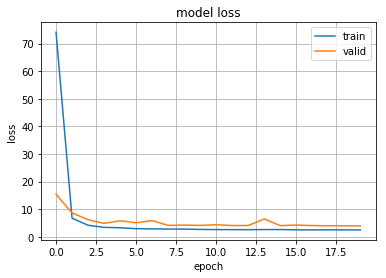

In [20]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.grid('on')
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "valid"], loc = "upper right")
plt.show()